1. Load boston setting X as boston.data and y as boston.target

- Attempt the grid search using polyregression + (linear, ridge, lasso, elastic net) 

- Does feature mechanisms on ridge/lasso/elastic helps here?

- What is the optimal polynomial degree?  What does it mean?

- Why do you think the result is like this?

- What is the value of lambdas, and what does it means?

In [1]:
from sklearn.datasets import load_boston

boston = load_boston()
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

In [2]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [3]:
# YOURE CODE HERE

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

import pandas as pd
import numpy as np

#we know in advance that ElasticNet gonna complain about
#needing more iterations.  Unfortunately, to prevent my pc 
#from crashing, I will simply ignore this warning, and
#likely set the tol to a bit high
warnings.filterwarnings("ignore", category=ConvergenceWarning,
                        module="sklearn")

boston = load_boston()
X = boston.data
y = boston.target
X = scaler.fit_transform(X)  #by scaling it helps reach convergence faster

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.3, random_state=5)

params_linear = {'polynomialfeatures__degree': np.arange(1, 10)}
linear = make_pipeline(PolynomialFeatures(), LinearRegression(normalize=True))
params_Ridge = {'polynomialfeatures__degree': np.arange(1, 10),
                'ridge__alpha': np.logspace(-1, -4, 4)}
ridge = make_pipeline(PolynomialFeatures(), Ridge(normalize=True))  
params_Lasso = {'polynomialfeatures__degree': np.arange(1, 10),
                'lasso__alpha': np.logspace(-1, -4, 4)}
lasso = make_pipeline(PolynomialFeatures(), 
                      Lasso(normalize=True))
params_Elasticnet = {'polynomialfeatures__degree': np.arange(1, 10),
                'elasticnet__alpha': np.logspace(-1, -4, 4),
                "elasticnet__l1_ratio": np.linspace(0, 1, 3)}
elastic = make_pipeline(PolynomialFeatures(), 
                      ElasticNet(normalize=True))

params = [params_linear, params_Ridge, params_Lasso, params_Elasticnet]
models = [linear, ridge, lasso, elastic]
features_name = ['linearregression', 'ridge', 'lasso', 'elasticnet']

for ix, model in enumerate(models):
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state=42)
    print(model)
    grid = GridSearchCV(model, params[ix], cv=cv)
    
    #grid.fit will fit the model at each grid point
    grid.fit(X_train, y_train)

    #print the best parameters
    print("Best params: ", grid.best_params_)

    #make prediction
    model = grid.best_estimator_
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #print the stats
    print("Coefficients: ", model.named_steps[features_name[ix]].coef_)
    print(f"r^2 = {r2_score(y_test, y_pred):.3f}")
    print(f"MSE = {mean_squared_error(y_test, y_pred):.2f}")
    n, p = X.shape[0], X.shape[1]
    adjusted_rsqrt = 1-(1-r2_score(y_test, y_pred))*(n-1)/(n-p-1)
    print(f"adjusted $r^2$ = {adjusted_rsqrt:.3f}")

'''
We can quickly tell that there are some less relevant features in this Boston dataset, which thus
lower the accuracy of the LinearRegression model.   Thus, Lasso and Ridge seems to provide much
better results; however, it is not yet clear which performs better.   

Alpha value also provides  us some good information, that is, alpha of 0.001 indicates that only slightly regularized
model is needed to improve the accuracy by almost 20 percent.

Looking at coefficients, let's say degree 1 from Ridge [coefficient number 1 - 14]: 

  -1.44816043e-01 -5.64496705e-02  3.98000454e-01
  4.38845564e-01 -8.51675780e-01  3.55010742e+00 -1.37778256e+00
 -1.86222774e+00  1.10837142e+00 -1.06506148e+00 -8.12821444e-01
  1.25327660e+00 -3.26288191e+00
  
It is clear that coefficient number 6 has the strongest impact toward targets,
while feature number 13 has the strongest inverse relationship with targets.  For example, 6 represents 
ROOM in dwellings which make sense to impact the price positively.  On the other hand, 13 represents the LSTAT which
is the percentage of the lower status of the population, thus naturally impact the price negatively.

Good thing is that all models share the same direction thus feature 6 and 13 seems to have the strongest impact.
Can you tell me which two features are the most unimportant?

Another point of observation is that the polynomial degree is around 1 and 2, which indicates
an almost linear relationship between boston data and boston target.

Adjusted r-square does not change dramatically, since the number of samples scale well with
number of features, thus the lower term (n - p - 1) is not dramatically different from only (n)

For elasticnet, interestingly, it chooses l1_ratio of 0.5, meaning a balance between Lasso and Ridge.
Anyhow, I am not sure how my pc fares, but it took a entire night! to complete the model for a mere
increae of 2% increase in accuracy, as compared to Lasso and Ridge.

In conclusion, the intuition is that there are some very prominent features but also some very irrelevant
features.  Thus regularized model will work better in this situation.  However, I would go for Ridge over
Elastic since it takes much less time to run.  However, if I want to understand the interaction between
l1 and l2 penalty, then I will run Elastic net.  Lasso will also be nice since all models suggest the second feature
- ZN - is very irrelevant to target, thus it might be useful to render it to 0., which Lasso and Elastic net does.
'''

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression(normalize=True))])
Best params:  {'polynomialfeatures__degree': 1}
Coefficients:  [ 0.         -1.32750493  0.96447433 -0.17391979  0.19945597 -1.49757922
  2.83543215 -0.2962689  -2.80831532  2.76854145 -2.12866545 -2.11368262
  1.15569647 -3.29628098]
r^2 = 0.677
MSE = 30.70
adjusted $r^2$ = 0.669
Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('ridge', Ridge(normalize=True))])
Best params:  {'polynomialfeatures__degree': 2, 'ridge__alpha': 0.01}
Coefficients:  [ 0.00000000e+00 -1.44816043e-01 -5.64496705e-02  3.98000454e-01
  4.38845564e-01 -8.51675780e-01  3.55010742e+00 -1.37778256e+00
 -1.86222774e+00  1.10837142e+00 -1.06506148e+00 -8.12821444e-01
  1.25327660e+00 -3.26288191e+00  1.63850840e-01  4.71665252e-01
 -1.16864891e-01  2.94839213e+00 -6.22042398e-01  3.06562044e-01
 -4.06958944e-01  3.23915966e-01 -5.05610073e-01  7.88507767

"\nWe can quickly tell that there are some less relevant features in this Boston dataset, which thus\nlower the accuracy of the LinearRegression model.   Thus, Lasso and Ridge seems to provide much\nbetter results; however, it is not yet clear which performs better.   \n\nAlpha value also provides  us some good information, that is, alpha of 0.001 indicates that only slightly regularized\nmodel is needed to improve the accuracy by almost 20 percent.\n\nLooking at coefficients, let's say degree 1 from Ridge [coefficient number 1 - 14]: \n\n  -1.44816043e-01 -5.64496705e-02  3.98000454e-01\n  4.38845564e-01 -8.51675780e-01  3.55010742e+00 -1.37778256e+00\n -1.86222774e+00  1.10837142e+00 -1.06506148e+00 -8.12821444e-01\n  1.25327660e+00 -3.26288191e+00\n  \nIt is clear that coefficient number 6 has the strongest impact toward targets,\nwhile feature number 13 has the strongest inverse relationship with targets.  For example, 6 represents \nROOM in dwellings which make sense to impact the

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model

2. Use below data
- Perform Ridge regression
- Plot training and validation errors as function of lambda
- Plot coefficients and coefficients error as function of lambda
    - coefficients can be obtained simply using model.coef_
    - coeffcient error can be computed using mean_squared_error(model.coef_, w)
- Interpret what is happening

In [5]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#only 10 out of 100 features are informative, add some noise to add to the difficulty of the problem
X, y, coef = make_regression(n_samples = 1000, n_features = 100, coef=True,
                         random_state=42, bias=6, noise=50, n_informative=10)

#scaling does not really help with simple linear regression
#since the coefficients can be multiply to certain order but
#with same result.  However, regularized models will be
#affected.  The idea is that the constraint is applied to the
#sum of a function of coefficients.  If we inflate an attribute,
#the coefficient will be deflated, which will affect
#the penalization.  Thus it is best to scale for all regression
#problems since it does not hurt
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

'\nFor big lambdas, coefficients are moving to "near" zero (but not zero!), forcing the model\nto be a simpler version.  \n\nFor the right graph, expectedly, once lambdas is big,\nthe difference between original coefficient and new coefficient will be big\n\nFor MSE, it shares the same info as coefficients error.  The sweet spot seems to be values\nbefore 10e-2 before strongly regularized model suffers from underfittig since the \ncoefficients are too small.\n\n'

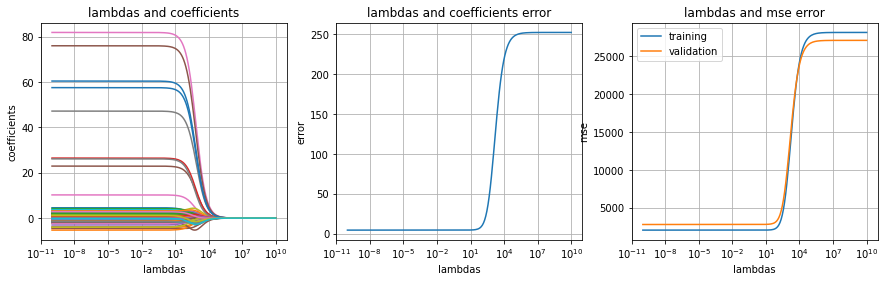

In [6]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

coefs = []
coefs_errors = []
train_errors = []
validation_errors = []

lambs = np.logspace(-10, 10, 200)

#loop through
for lamb in lambs:
    model = Ridge(alpha = lamb)
    model.fit(X_train, y_train)
    pred = model.predict(X_train)
    train_errors.append(mean_squared_error(y_train, pred))
    pred = model.predict(X_test)
    validation_errors.append(mean_squared_error(y_test, pred))
    coefs.append(model.coef_)
    coefs_errors.append(mean_squared_error(model.coef_, coef))
    
# Display results
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].grid()
ax[0].plot(lambs, coefs)
ax[0].set_xscale('log')
ax[0].set_xlabel('lambdas')
ax[0].set_ylabel('coefficients')
ax[0].set_title('lambdas and coefficients')

ax[1].grid()
ax[1].plot(lambs, coefs_errors)
ax[1].set_xscale('log')
ax[1].set_xlabel('lambdas')
ax[1].set_ylabel('error')
ax[1].set_title('lambdas and coefficients error')

ax[2].grid()
ax[2].plot(lambs, train_errors, label="training")
ax[2].plot(lambs, validation_errors, label="validation")
ax[2].set_xscale('log')
ax[2].set_xlabel('lambdas')
ax[2].set_ylabel('mse')
ax[2].set_title('lambdas and mse error')
ax[2].legend()

'''
For big lambdas, coefficients are moving to "near" zero (but not zero!), forcing the model
to be a simpler version.  

For the right graph, expectedly, once lambdas is big,
the difference between original coefficient and new coefficient will be big

For MSE, it shares the same info as coefficients error.  The sweet spot seems to be values
before 10e-2 before strongly regularized model suffers from underfittig since the 
coefficients are too small.

'''

3. Using boston data, compare 

- OLS from scratch
- pseudo OLS from scratch
- gradient descent from scratch
- LinearRegression() by sklearn  

Measure which one is faster.  Try to vary the n_features.

So what do you think, closed_form or gradient descent?


In [7]:
from sklearn.metrics import mean_squared_error
from numpy.linalg import inv
from time import time
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def linear_regression_ols(X, y, num_feature, pseudo=False):
    X = X[:, :num_feature]
    
    #traditional OLS
    #remember that OLS has the assumption of full-column rank
    #which means the number of samples should be greater than number of features
w = inv(X.T.dot(X)).dot(X.T).dot(y)
   
    #another way using pseudo-inverse (robust if matrix violates full-column rank)
    if(pseudo):
        #many ways to perform dot such as np.dot....you can also use @!
        w = np.dot(np.linalg.pinv(X), y)
    return w
    
def linear_regression_gradient(X, y, num_feature, max_iter=10, tol=0.0001):
    X = X[:, :num_feature]
    w = np.zeros(X.shape[1]) #+1 for intercept
    
    m = len(y)
    l_rate = 0.01 #actually need adaptive learning rate
    
    #good question is how many iteration
    #perhaps you can set a variable called tol
    #and if the mse falls in some range, its ok
    for i in range(max_iter):
        pred = get_pred(X, w)
        if (mean_squared_error(y, pred) < tol):
            break
        error = pred - y
        
        #update w by minus its partial derivates
        #if you do not add 1 for intercept, you have to do like this
#         w[0] = w[0] - ((l_rate * 1/m) * error.sum())  #remember to set w np.zeros(X.shape[1] + 1)
#         w[1:] = w[1:] - ((l_rate * 1/m) * np.dot(X.T, error))
        w = w - ((l_rate * 1/m) * np.dot(X.T, error))
    return w, i

def get_pred(X, w):
    return X @ w

boston = load_boston()
X = boston.data
y = boston.target

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

intercept = np.ones((X_train.shape[0], 1))
X_train = np.concatenate((intercept, X_train), axis=1)  #add intercept

intercept = np.ones((X_test.shape[0], 1))
X_test = np.concatenate((intercept, X_test), axis=1)  #add intercept

test_num_feature = np.linspace(1, X.shape[1], 5, dtype=int)

#you probably want to write as class for below code
#way too many boiler code!
print("===Gradient Descent===")
for num_feature in test_num_feature: 
    start = time()
    w, i = linear_regression_gradient(X_train, y_train, num_feature=num_feature, max_iter=2000)
    pred = get_pred(X_test[:, :num_feature], w)
    print(f"Results finish using {i+1} iteration and {num_feature} features with MSE of " +
    f"{mean_squared_error(y_test, pred)}" + 
        f" using time of {time() - start}")

print("===OLS===")
for num_feature in test_num_feature: 
    start = time()
    w = linear_regression_ols(X_train, y_train, num_feature=num_feature)
    pred = get_pred(X_test[:, :num_feature], w)
    print(f"Results finish using {num_feature} features with MSE of " +
    f"{mean_squared_error(y_test, pred)}" + 
        f" using time of {time() - start}")
    
print("===OLS using pseudo-inverse==")
#I found pseudo-inverse to work much better than ols when full-rank assumption is violated
#for example, try make X with n_features more than n_samples...
for num_feature in test_num_feature: 
    start = time()
    w = linear_regression_ols(X_train, y_train, num_feature=num_feature, pseudo=True)
    pred = get_pred(X_test[:, :num_feature], w)
    print(f"Results finish using {num_feature} features with MSE of " +
    f"{mean_squared_error(y_test, pred)}" + 
        f" using time of {time() - start}")
    
print("===OLS using sklearn LinearRegression==")
#I found pseudo-inverse to work much better than ols when full-rank assumption is violated
#for example, try make X with n_features more than n_samples...
for num_feature in test_num_feature: 
    start = time()
    model = LinearRegression().fit(X_train[:, :num_feature], y_train)
    pred = model.predict(X_test[:, :num_feature])
    print(f"Results finish using {num_feature} features with MSE of " +
            f"{mean_squared_error(y_test, pred)}" + 
            f" using time of {time() - start}")
    
'''
Several interesting points can be said here.

It is clear to me that OLS performs much faster, since OLS solves it with one go.  In addition, closed form always 
perform with with highest accuracy (even overfitting) given that closed form
solves the equation directly, aiming for highest accuracy (i.e., highest variance).  However, this does not mean
Gradient Descent is not accurate since you can keep on running loops on Gradient Descent and reach the same MSE
eventually.  But I think the key here is that closed form performs much faster than Gradient Descent.

Note that all algorithms cap at MSE of 2995 regardless of algorithms.  This is likely because this is the best
these linear models can perform given the noise and n_informative features.

You also never want to use Gradient Descent since the better one is Stochastic Gradient Descent in most situations,
since Stochastic Descent used only one sample at a time to estimate the udpate, thus reduce the
computational complexity (of course, we gonna implement that in the next question!).  SGD will show its power
especially when working on large datasets.  However, since SGD randomize sample everytime, the update
can go awry sometimes and MSE tend to be bigger

There are two situations you want to use descent algorithms over closed form:
- When your X matrix cannot meet OLS assumption, e.g., a lot of zeros thus cannot be inversed, or not full-column rank
- The complexity of inversing a matrix is roughly O(n^3) where n is dimension or number of features.  Here
  we use n = 100 but seems like closed_form still outperform in terms of time.  I do not have powerful
  machine yet on my hand, but theoretically, at certain very large n, descent algorithm "may" be faster.  You can 
  try more n_features but be careful your pc will take long long long time :)

It is also good to mention that closed form is not possible for Lasso (except for univarate linear regression - 
i.e., with one x).  Thus Lasso in sklearn implements coordinate descent which updates only one wi (for example,
w associating with x1) at a time, whereas gradient descent shall update the whole w for all x every iteration.
More readings: https://www.ias.ac.in/public/Volumes/reso/023/04/0439-0464.pdf
'''

===Gradient Descent===
Results finish using 2000 iteration and 1 features with MSE of 27116.879952565396 using time of 0.27852869033813477
Results finish using 2000 iteration and 25 features with MSE of 26083.620377006748 using time of 0.5331752300262451
Results finish using 2000 iteration and 50 features with MSE of 24173.261833723955 using time of 0.5372612476348877
Results finish using 2000 iteration and 75 features with MSE of 19989.39110329111 using time of 0.663320779800415
Results finish using 2000 iteration and 100 features with MSE of 2779.6744832872973 using time of 0.6129424571990967
===OLS===
Results finish using 1 features with MSE of 27116.87995260446 using time of 0.00022673606872558594
Results finish using 25 features with MSE of 26083.620348328033 using time of 0.000392913818359375
Results finish using 50 features with MSE of 24173.267760591265 using time of 0.0007932186126708984
Results finish using 75 features with MSE of 19989.480648247227 using time of 0.0011167526

'\nSeveral interesting points can be said here.\n\nIt is clear to me that OLS performs much faster, since OLS solves it with one go.  In addition, closed form always \nperform with with highest accuracy (even overfitting) given that closed form\nsolves the equation directly, aiming for highest accuracy (i.e., highest variance).  However, this does not mean\nGradient Descent is not accurate since you can keep on running loops on Gradient Descent and reach the same MSE\neventually.  But I think the key here is that closed form performs much faster than Gradient Descent.\n\nNote that all algorithms cap at MSE of 2995 regardless of algorithms.  This is likely because this is the best\nthese linear models can perform given the noise and n_informative features.\n\nYou also never want to use Gradient Descent since the better one is Stochastic Gradient Descent in most situations,\nsince Stochastic Descent used only one sample at a time to estimate the udpate, thus reduce the\ncomputational com

4. Implement Ridge regression from scratch using 

 - the closed form OLS

 - stochastic gradient descent

 - SGDRegressor() of sklearn using penalty as l2

 - Ridge() by sklearn

Loop through several lambda and 
 - Print the MSE
 - Compare the time as well

Use this below data

'\nIt is clear to me that OLS (OLS and sklearn-Ridge) again performs much faster and accurate than both Descent algorithm.  \nNote that our custom SGD algorithm takes much more time than sklearn SGD, probably because sklearn has some optimization, or\nour SGD implementation is under optimized!\n\nIt is also clear to see that sklearn SGD performs much faster than our GD algorithm as expected.  However,\nthere is never free thing exists in the world, so SGD is less robust to increase in MSE.\n\nYou only want to use SGD over closed form when your matrix does not meet OLS assumptions or you have \nway too many features.  Note that there is no closed-form soution for Lasso, so sklearn implement something\ncalled coordinate descent instead.\n\nOne last thing but probably the most important, Ridge regression outperform LinearRegression in MSE.  Given\nappropriate lambda, Ridge MSE approach zero for both validation and training errors.  Ridge was\nable to shine here since we select n_informati

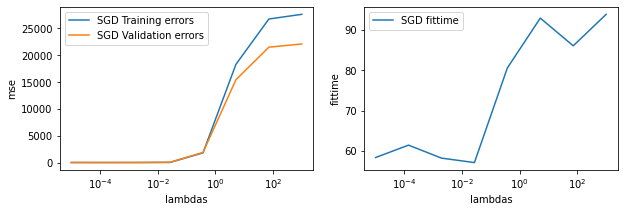

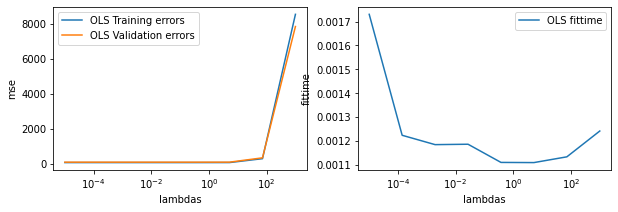

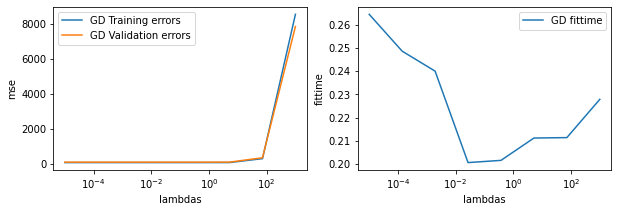

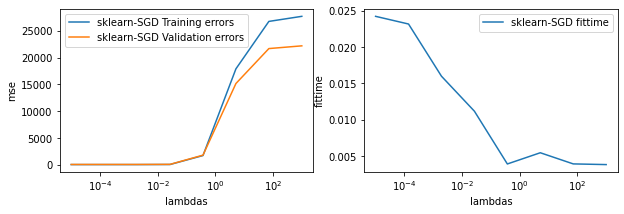

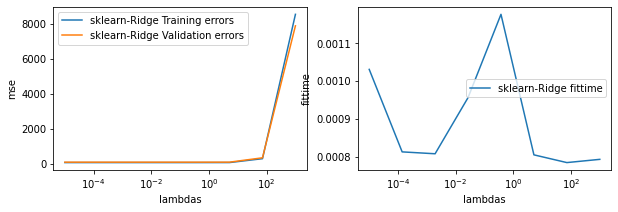

In [8]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from time import time
from sklearn.metrics import mean_squared_error

def get_pred(X, w):
    return X @ w

def ridge_ols(X, y, lamb):
    # Get identity matrix
    I = np.eye(X.shape[1])
    
    # Set up equations (X^T dot X + lambda * I) dot w = X^T dot y        
    # Solve for w
    # use @ for dot, for easier readability...if you like
    w = np.linalg.solve((X.T @ X) + lamb * I, X.T @ y)
    return w

def ridge_sgd(X, y, lamb, max_iter=1000, tol=0.001):
    w = np.zeros(X.shape[1])
    m = len(y)  #or X.shape[0]
    l_rate = 0.01
    for i in range(max_iter):
        for j in range(X.shape[0]):  #get only some rows
            random_row_to_pick = np.random.randint(0, X.shape[0])
            X_i = X[random_row_to_pick, :].reshape(1, X_train.shape[1])
            y_i = y[[random_row_to_pick]] #shape (n, )
            pred = get_pred(X_i, w)
            if (mean_squared_error(y_i, pred) < tol):
                break
            error = pred - y_i
            w = w - (l_rate / m) * (np.dot(X_i.T, error) + lamb * w)
    return w

def ridge_gd(X, y, lamb, max_iter=1000, tol=0.001):
    w = np.zeros(X.shape[1])
    m = len(y)  #or X.shape[0]
    l_rate = 0.01
    for i in range(max_iter):
        pred = get_pred(X, w)
        if (mean_squared_error(y, pred) < tol):
            break
        error = pred - y
        w = w - (l_rate / m) * (np.dot(X.T, error) + lamb * w)
    return w

def plot_lambdas_mse(lambs, training_errors, validation_errors, fittime, modifier="OLS"):
    _, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax[0].plot(lambs, training_errors, label=f"{modifier} Training errors")
    ax[0].plot(lambs, validation_errors, label=f"{modifier} Validation errors")
    ax[0].set_xscale('log')
    ax[0].set_xlabel("lambdas")
    ax[0].set_ylabel("mse")
    ax[0].legend()
    ax[1].plot(lambs, fittime, label=f"{modifier} fittime")
    ax[1].set_xscale('log')
    ax[1].set_xlabel("lambdas")
    ax[1].set_ylabel("fittime")
    ax[1].legend()

#decided to write this to avoid all these boiler codes!
def apply(X_train, X_test, y_train, y_test, lamb, modifier, use_sklearn, f):
    lambs = np.logspace(-5, 3, 8)
    training_errors = []
    validation_errors = []
    fittime = []
    
    for lamb in lambs: 
        start = time()
        if not (use_sklearn):
            w = f(X_train, y_train, lamb)
            fittime.append(time() - start)
            pred = get_pred(X_train, w)
            training_errors.append(mean_squared_error(y_train, pred))
            pred = get_pred(X_test, w)
            validation_errors.append(mean_squared_error(y_test, pred))
        else:
            model = f(alpha=lamb).fit(X_train, y_train)
            fittime.append(time() - start)
            pred = model.predict(X_train)
            training_errors.append(mean_squared_error(y_train, pred))
            pred = model.predict(X_test)
            validation_errors.append(mean_squared_error(y_test, pred))
    
    plot_lambdas_mse(lambs, training_errors, validation_errors, fittime, modifier)
    
X, y, coef = make_regression(n_samples = 1000, n_features = 100, coef=True,
                         random_state=42, bias=6, noise=10, n_informative=10)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

intercept = np.ones((X_train.shape[0], 1))
X_train = np.concatenate((intercept, X_train), axis=1)  #add intercept

intercept = np.ones((X_test.shape[0], 1))
X_test = np.concatenate((intercept, X_test), axis=1)  #add intercept

models = {"SGD": ridge_sgd, "OLS": ridge_ols, "GD": ridge_gd,
                  "sklearn-SGD": SGDRegressor, "sklearn-Ridge": Ridge}
use_sklearn = [False, False, False, True, True]

for ix, (modifier, model)  in enumerate(models.items()):
    apply(X_train, X_test, y_train, y_test, 0.01, modifier, use_sklearn[ix], model)

'''
It is clear to me that OLS (OLS and sklearn-Ridge) again performs much faster and accurate than both Descent algorithm.  
Note that our custom SGD algorithm takes much more time than sklearn SGD, probably because sklearn has some optimization, or
our SGD implementation is under optimized!

It is also clear to see that sklearn SGD performs much faster than our GD algorithm as expected.  However,
there is never free thing exists in the world, so SGD is less robust to increase in MSE.

You only want to use SGD over closed form when your matrix does not meet OLS assumptions or you have 
way too many features.  Note that there is no closed-form soution for Lasso, so sklearn implement something
called coordinate descent instead.

One last thing but probably the most important, Ridge regression outperform LinearRegression in MSE.  Given
appropriate lambda, Ridge MSE approach zero for both validation and training errors.  Ridge was
able to shine here since we select n_informative = 10 out of 100 features, thus there are at least
90 features that are less informative/relevant.
'''
